In [ ]:
---
title: Classifying Palmer Penguins
author: Carly McAdam
date: '2025-02-26'
image: "penguins.jpg"
description: "Classifying Palmer Penguins"
format: html
---

In this blog post we are going to train a model to classify penguin species based on features in the Palmer Penguins dataset. We will begin by reading in a preprocessing the dataset. 

In [11]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

In [13]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


Now, we'll look at some visualizations of some of the features in the dataset in order to get an idea of which ones will work well for classification. 

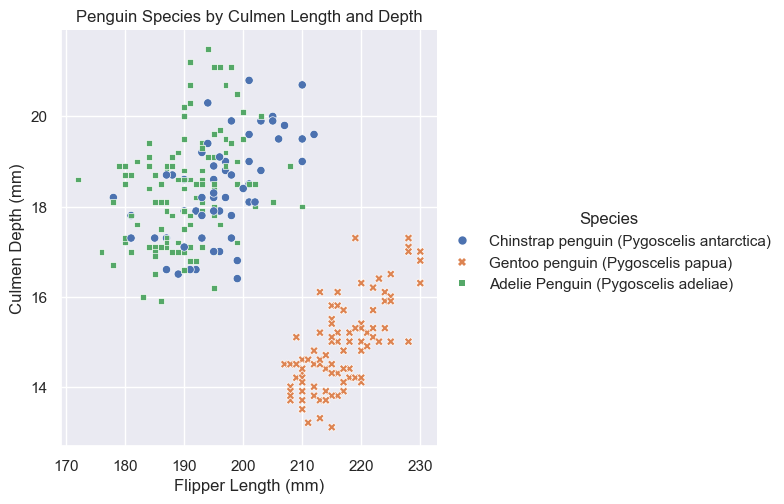

In [23]:
import seaborn as sns

sns.set_theme()

sns.relplot(
    data=train,
    x="Flipper Length (mm)", y="Culmen Depth (mm)",
    hue="Species", style="Species"
).set(title="Penguin Species by Culmen Depth and Flipper Length")

/var/folders/23/gcqcls_x0glfvcgh87xqjsjr0000gn/T/ipykernel_14686/2202003667.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


[Text(0, 0, 'Dream'), Text(1, 0, 'Biscoe'), Text(2, 0, 'Torgersen')]

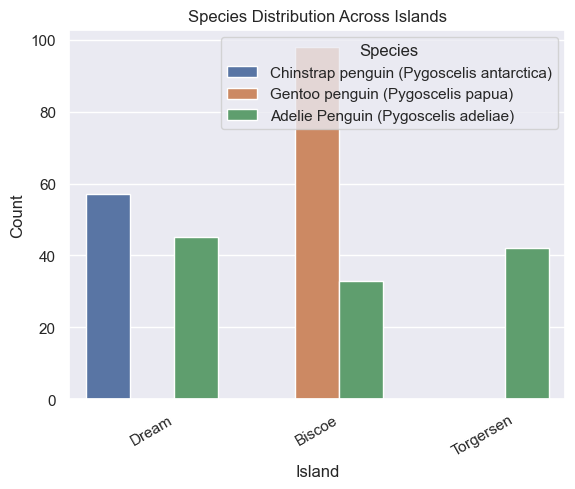

In [16]:
ax = sns.countplot(data=train, x="Island", hue="Species")
ax.set(xlabel="Island", ylabel="Count", title="Species Distribution Across Islands")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [27]:
grouped_data = train.groupby("Species").agg({"Culmen Length (mm)" : "mean"})
grouped_data

,Culmen Length (mm)
Species,
Adelie Penguin (Pygoscelis adeliae),38.970588
Chinstrap penguin (Pygoscelis antarctica),48.826316
Gentoo penguin (Pygoscelis papua),47.073196


Our goal is to find three features that will allow us to train a model which will be 100% accurate in predicting the species of a penguin in the training set. We can ascertain some information about the top scored features from these plots that will be helpful to determine if these features will work. 

 First, we can see that the Gentoo penguin has different culmen and flipper measurements than the Chinstrap and Adelie penguins. Specifically, the Gentoo penguin seems to have a larger flipper length and a shallower culmen depth than the Chinstrap and Adelie penguins. This relationship can be used to identify the Gentoo penguins, but we still need to find a way to distinguish between the Chinstrap and Adelie penguins. 
 
 The second plot provides a way to do this; the Chinstrap penguins are only found on Dream Island. We can also see that the Adelie penguins are found on all three islands, and the Gentoo penguin is only found on Biscoe Island. In the summary table, we can see that there is also a difference in culmen length between the species. The Chinstrap and Gentoo penguins have similar average culmen lengths, but the Adelie penguins have much shorter culmens on average.  

Using some combination of these features, we should be able to accurately predict the species of any penguin in the training set. We will use tree-based feautre selection to determine which of the features we will use to train our model. 

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
tree_selector = ExtraTreesClassifier(n_estimators=100, random_state=42)
tree_selector.fit(X_train, y_train)

feature_importances = tree_selector.feature_importances_

feature_scores = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importances})

feature_scores = feature_scores.sort_values(by="Importance", ascending=False)

print("Top 10 Features:")
print(feature_scores.head(10))

Top 10 Features:
                Feature  Importance
0    Culmen Length (mm)    0.166972
2   Flipper Length (mm)    0.139796
6         Island_Biscoe    0.132696
5     Delta 13 C (o/oo)    0.131550
1     Culmen Depth (mm)    0.107809
7          Island_Dream    0.097487
3         Body Mass (g)    0.096845
4     Delta 15 N (o/oo)    0.055263
8      Island_Torgersen    0.044637
12           Sex_FEMALE    0.010332


We can see from the feature selector that the culmen length, flipper length, and the island are the most important features in the dataset. So, we will use these features to train our model. We will use a decision tree 

In [39]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
import numpy as np

cols = ["Flipper Length (mm)", "Culmen Length (mm)", "Island_Biscoe", "Island_Dream","Island_Torgersen"]

depths = range(1, 21)
mean_scores = []

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(dt, X_train[cols], y_train, cv=5, scoring='accuracy')
    mean_scores.append(np.mean(scores))

best_depth = depths[np.argmax(mean_scores)]
best_score = max(mean_scores)

print(f"Best max_depth: {best_depth}")
print(f"Best cross-validated accuracy: {best_score}")

Best max_depth: 5
Best cross-validated accuracy: 0.9765460030165911


Based on the cross-validation, a decision tree with depth 5 is the best option for our model. Next, we'll train this model. 

In [47]:
dt_model = tree.DecisionTreeClassifier(max_depth=5, random_state=42)

dt_model.fit(X_train[cols], y_train)

train_accuracy = dt_model.score(X_train[cols], y_train)

print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9922


Now that we've trained this decision tree, we can test it on the test dataset 

In [48]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
dt_model.score(X_test[cols], y_test)

0.9852941176470589

In [49]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

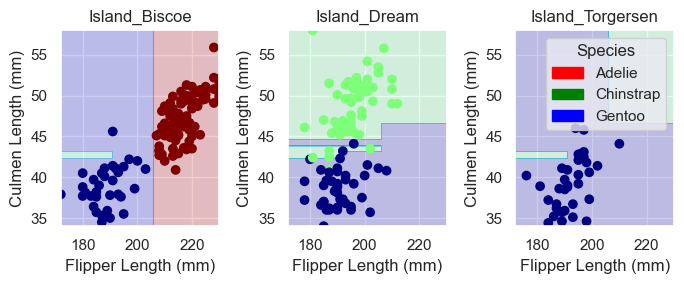

In [50]:
plot_regions(dt_model, X_train[cols], y_train)

In [53]:
from sklearn.metrics import confusion_matrix

y_test_pred = dt_model.predict(X_test[cols])
C = confusion_matrix(y_test, y_test_pred)

for i in range(3):
    for j in range(3):
        print(f"There were {C[i,j]} {le.classes_[i]} penguin(s) who were classified as {le.classes_[j]}.")

There were 31 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 0 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 11 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 1 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were

This model was very accurate, and it only missclassified a single penguin, which was a Gentoo penguin classified as an Adelie penguin. 